In [1]:
# Insights:

# - Dataplacement reveals where & how data is stored in memory. For a given dataplacement:

#   -> Only certain dataflows make sense.


# Dataplacement and dataflow determine how the bound(s) of each loop impact tile shapes,
# number of accesses, memory footprint, energy, and latency. Once we've picked a
# dataplacement and dataflow, there's are clear, easy-to-reason-about functions that
# convert tile shape(s) to these values. For a given dataplacement & dataflow:

#   -> We can run a complex model once that generates these functions, and then use them
#   to quickly evaluate many different tile shapes.


# Now we have a set of functions that make it easy to reason about the impact of different
# tile shape choices. For a given partially-complete set of tile shapes:

#   -> Some mappings can be found invalid (e.g., a single tile exceeds the memory
#   footprint even without determining the size of other tiles).

#   -> Some mappings are clearly worse than others (e.g., can tell that tile shape choices
#   ($a, b, c$) cause higher energy than ($b$, $c$, $d$) regardless of the choices for
#   other tile shapes).

# Speedups:
# - Invalid check: 33x
# -

# Pmapping counting
import fastfusion as ff
import fastfusion.mapper.FFM._make_pmappings.mapper_one_einsum.mapper_one_einsum as mapper_one_einsum
import fastfusion.mapper.FFM._make_pmappings.mapper_one_einsum.tile_shape_exploration as tile_shape_exploration
from math import log10

for x in (True,):#, False:
    if x:
        arch = "../examples/arches/tpu_v4i_like.arch.yaml"
        workload = "../examples/workloads/gpt3_6.7B.yaml"
    else:
        arch = "../examples/arches/nvdla_like.arch.yaml"
        workload = "../examples/workloads/mobilenet_28.workload.yaml"

    spec = ff.Specification.from_yaml(
        arch,
        workload,
        jinja_parse_data={
            "BATCH_SIZE": 64,
            "N_TOKENS": 65536,
        }
    )

    spec.arch["ArrayDummy"].constraints.spatial["reuse_input"].min_utilization = 0#0
    spec.arch["ArrayDummy"].constraints.spatial["reuse_output"].min_utilization = 0#0
    spec.arch["MainMemory"].constraints.tensors.keep = "All"
    spec.arch["GlobalBuffer"].constraints.tensors.keep = "output | input | ~MainMemory"
    spec.arch["GlobalBuffer"].constraints.tensors.may_keep = "weight | ~MainMemory"
    if "tpu_v4i" in arch:
        # spec.arch["LocalBuffer"].constraints.spatial.append(ff.constraints.Spatial(name="Z", min_utilization=1))
        spec.arch["LocalBuffer"].constraints.tensors.keep = "input | output"
        spec.arch["LocalBuffer"].constraints.tensors.may_keep = "weight"

    spec.mapper.ffm.metrics = ff.Metrics.ENERGY # | ff.Metrics.LATENCY

    # ! rm -r cache

    def run_mapper(spec: ff.Specification, count_option: str):
        spec.mapper.ffm._count_option_for_mapsapce_size_evaluation = count_option
        return ff.mapper.FFM.make_pmappings(spec)#, cache_dir="cache")

    ff.set_n_parallel_jobs(32)

    # total = run_mapper(spec, "redundant_loop_orders_and_irrelevant_loops_and_redundant_dataplacements")
    # no_redundant_dataplacements = run_mapper(spec, "redundant_loop_orders_and_irrelevant_loops")
    # no_irrelevant_loops = run_mapper(spec, "redundant_loop_orders")
    # normal = run_mapper(spec, "normal")

    normal = run_mapper(spec, ())
    total = run_mapper(spec, ("redundant_dataplacements", "non_helpful_loops_for_loop_orders", "non_helpful_tile_shapes", "redundant_loop_orders"))
    no_redundant_dataplacements = run_mapper(spec, ("non_helpful_loops_for_loop_orders", "non_helpful_tile_shapes", "redundant_loop_orders"))
    no_non_helpful_tile_shapes = run_mapper(spec, ("non_helpful_loops_for_loop_orders", "redundant_loop_orders"))
    no_non_helpful_loops_for_loop_orders = run_mapper(spec, ("redundant_loop_orders"))

WARNING Loading configuration file from /home/tanner/fastfusion/venv/fastfusion/config.yaml
Generating pmapping templates for compute ScalarUnit Einsum I: 1it [00:00, 10.58it/s]
Generating pmapping templates for compute ScalarUnit Einsum V: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum K: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum Q: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s]t [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum QK: 0it [00:00, ?it/s]]
Generating pmapping templates for compute ScalarUnit Einsum AV: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum FFB: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum Z: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum FFA: 0it

V: 2.51e26 total, 2.41e25 (1/10) valid, 5.20e06 (1/4.82e19) evaluated, 1 (1/2.51e26) Pareto-Optimal
Q: 2.51e26 total, 2.41e25 (1/10) valid, 5.01e06 (1/5.01e19) evaluated, 1 (1/2.51e26) Pareto-Optimal
Z: 2.51e26 total, 3.21e25 (1/8) valid, 1.32e07 (1/1.90e19) evaluated, 1 (1/2.51e26) Pareto-Optimal
K: 2.51e26 total, 2.41e25 (1/10) valid, 5.01e06 (1/5.01e19) evaluated, 1 (1/2.51e26) Pareto-Optimal
FFA: 1.29e26 total, 3.09e25 (1/4) valid, 7.99e06 (1/1.61e19) evaluated, 1 (1/1.29e26) Pareto-Optimal
FFB: 1.29e26 total, 1.73e25 (1/7) valid, 8.05e06 (1/1.60e19) evaluated, 1 (1/1.29e26) Pareto-Optimal
QK: 6.44e25 total, 2.35e21 (1/2.75e04) valid, 7.50e06 (1/8.59e18) evaluated, 1 (1/6.44e25) Pareto-Optimal
AV: 6.44e25 total, 1.96e21 (1/3.29e04) valid, 8.37e06 (1/7.70e18) evaluated, 1 (1/6.44e25) Pareto-Optimal
QK_softmax: 1.26e17 total, 76 (1/1.66e15) valid, 176 (1/7.15e14) evaluated, 1 (1/1.26e17) Pareto-Optimal
I: 1.05e13 total, 13 (1/8.07e11) valid, 25 (1/4.20e11) evaluated, 1 (1/1.05e13) Pa

Generating pmapping templates for compute ScalarUnit Einsum I: 1it [00:00, 22.79it/s]
Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum V: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum K: 0it [00:00, ?it/s]]]
Generating pmapping templates for compute ScalarUnit Einsum Q: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum QK: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum AV: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum FFA: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum FFB: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum Z: 0it [00:00, ?it/s]0, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum QK_softmax: 4it [00:00

V: 6.11e50 total, 1.88e32 (1/3.26e18) valid, 0 (1/inf) evaluated, 1 (1/6.11e50) Pareto-Optimal
Z: 6.11e50 total, 1.88e32 (1/3.26e18) valid, 0 (1/inf) evaluated, 1 (1/6.11e50) Pareto-Optimal
K: 6.11e50 total, 1.88e32 (1/3.26e18) valid, 0 (1/inf) evaluated, 1 (1/6.11e50) Pareto-Optimal
Q: 6.11e50 total, 1.88e32 (1/3.26e18) valid, 0 (1/inf) evaluated, 1 (1/6.11e50) Pareto-Optimal
FFA: 3.24e44 total, 2.27e32 (1/1.42e12) valid, 0 (1/inf) evaluated, 1 (1/3.24e44) Pareto-Optimal
FFB: 3.24e44 total, 2.27e32 (1/1.42e12) valid, 0 (1/inf) evaluated, 1 (1/3.24e44) Pareto-Optimal
QK: 3.54e52 total, 4.49e28 (1/7.88e23) valid, 0 (1/inf) evaluated, 1 (1/3.54e52) Pareto-Optimal
AV: 3.54e52 total, 4.49e28 (1/7.88e23) valid, 0 (1/inf) evaluated, 1 (1/3.54e52) Pareto-Optimal
I: 6.30e13 total, 9.73e05 (1/6.47e07) valid, 0 (1/inf) evaluated, 1 (1/6.30e13) Pareto-Optimal
QK_softmax: 3.02e18 total, 1.72e08 (1/1.75e10) valid, 0 (1/inf) evaluated, 1 (1/3.02e18) Pareto-Optimal
Total: 7.33e52 total, 1.20e33 (1/6.

Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s], ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum I: 1it [00:00, 19.56it/s]it/s]
Generating pmapping templates for compute ScalarUnit Einsum V: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum Q: 0it [00:00, ?it/s]]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum QK: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum AV: 0it [00:00, ?it/s]]
Generating pmapping templates for compute ScalarUnit Einsum FFA: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum Z: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum QK_softmax: 4it [00:00, 37.08it/s]
Generating pmapping templates for compute ScalarUnit Einsum FFB: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum K: 0i

V: 6.11e50 total, 1.88e32 (1/3.26e18) valid, 0 (1/inf) evaluated, 1 (1/6.11e50) Pareto-Optimal
K: 6.11e50 total, 1.88e32 (1/3.26e18) valid, 0 (1/inf) evaluated, 1 (1/6.11e50) Pareto-Optimal
Q: 6.11e50 total, 1.88e32 (1/3.26e18) valid, 0 (1/inf) evaluated, 1 (1/6.11e50) Pareto-Optimal
Z: 6.11e50 total, 1.88e32 (1/3.26e18) valid, 0 (1/inf) evaluated, 1 (1/6.11e50) Pareto-Optimal
FFA: 3.23e44 total, 2.27e32 (1/1.42e12) valid, 0 (1/inf) evaluated, 1 (1/3.23e44) Pareto-Optimal
FFB: 3.23e44 total, 2.27e32 (1/1.42e12) valid, 0 (1/inf) evaluated, 1 (1/3.23e44) Pareto-Optimal
QK: 3.54e52 total, 4.49e28 (1/7.89e23) valid, 0 (1/inf) evaluated, 1 (1/3.54e52) Pareto-Optimal
AV: 3.54e52 total, 4.49e28 (1/7.89e23) valid, 0 (1/inf) evaluated, 1 (1/3.54e52) Pareto-Optimal
QK_softmax: 3.02e18 total, 1.72e08 (1/1.75e10) valid, 0 (1/inf) evaluated, 1 (1/3.02e18) Pareto-Optimal
I: 6.30e13 total, 9.73e05 (1/6.47e07) valid, 0 (1/inf) evaluated, 1 (1/6.30e13) Pareto-Optimal
Total: 7.33e52 total, 1.20e33 (1/6.

Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s], ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum I: 1it [00:00, 20.37it/s]
Generating pmapping templates for compute ScalarUnit Einsum V: 0it [00:00, ?it/s]s] ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum K: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum Q: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum QK: 0it [00:00, ?it/s]]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum Z: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum FFA: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum FFB: 0it [00:00, ?it/s] 18.78it/s]
Generating pmapping templates for compute ScalarUnit Einsum QK_softmax: 4it [00:00, 27.23it/s]
Generating pmapping templates for compute ScalarUnit

V: 9.12e42 total, 1.88e32 (1/4.86e10) valid, 0 (1/inf) evaluated, 1 (1/9.12e42) Pareto-Optimal
Q: 9.12e42 total, 1.88e32 (1/4.86e10) valid, 0 (1/inf) evaluated, 1 (1/9.12e42) Pareto-Optimal
K: 9.12e42 total, 1.88e32 (1/4.86e10) valid, 0 (1/inf) evaluated, 1 (1/9.12e42) Pareto-Optimal
Z: 9.12e42 total, 1.88e32 (1/4.86e10) valid, 0 (1/inf) evaluated, 1 (1/9.12e42) Pareto-Optimal
FFA: 1.19e37 total, 2.27e32 (1/5.24e04) valid, 0 (1/inf) evaluated, 1 (1/1.19e37) Pareto-Optimal
FFB: 1.19e37 total, 2.27e32 (1/5.24e04) valid, 0 (1/inf) evaluated, 1 (1/1.19e37) Pareto-Optimal
QK: 2.06e42 total, 4.49e28 (1/4.59e13) valid, 0 (1/inf) evaluated, 1 (1/2.06e42) Pareto-Optimal
AV: 2.06e42 total, 4.49e28 (1/4.59e13) valid, 0 (1/inf) evaluated, 1 (1/2.06e42) Pareto-Optimal
I: 6.30e13 total, 9.73e05 (1/6.47e07) valid, 0 (1/inf) evaluated, 1 (1/6.30e13) Pareto-Optimal
QK_softmax: 3.02e18 total, 1.72e08 (1/1.75e10) valid, 0 (1/inf) evaluated, 1 (1/3.02e18) Pareto-Optimal
Total: 4.06e43 total, 1.20e33 (1/3.

Generating pmapping templates for compute ScalarUnit Einsum V: 0it [00:00, ?it/s]s] ?it/s]
Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum K: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum Q: 0it [00:00, ?it/s]]
Generating pmapping templates for compute ScalarUnit Einsum QK: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum AV: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum FFA: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum Z: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum FFB: 0it [00:00, ?it/s] 18.14it/s]
Generating pmapping templates for compute ScalarUnit Einsum QK_softmax: 4it [00:00, 28.18it/s]
Generating pmapping templates for compute ScalarUnit Einsum I: 

V: 1.08e29 total, 1.88e32 (1/0) valid, 0 (1/inf) evaluated, 1 (1/1.08e29) Pareto-Optimal
K: 1.08e29 total, 1.88e32 (1/0) valid, 0 (1/inf) evaluated, 1 (1/1.08e29) Pareto-Optimal
Z: 1.08e29 total, 1.88e32 (1/0) valid, 0 (1/inf) evaluated, 1 (1/1.08e29) Pareto-Optimal
Q: 1.08e29 total, 1.88e32 (1/0) valid, 0 (1/inf) evaluated, 1 (1/1.08e29) Pareto-Optimal
FFA: 5.10e27 total, 2.27e32 (1/0) valid, 0 (1/inf) evaluated, 1 (1/5.10e27) Pareto-Optimal
FFB: 5.10e27 total, 2.27e32 (1/0) valid, 0 (1/inf) evaluated, 1 (1/5.10e27) Pareto-Optimal
QK: 1.55e27 total, 4.49e28 (1/0) valid, 0 (1/inf) evaluated, 1 (1/1.55e27) Pareto-Optimal
AV: 1.55e27 total, 4.49e28 (1/0) valid, 0 (1/inf) evaluated, 1 (1/1.55e27) Pareto-Optimal
QK_softmax: 3.02e18 total, 1.72e08 (1/1.75e10) valid, 0 (1/inf) evaluated, 1 (1/3.02e18) Pareto-Optimal
I: 6.30e13 total, 9.73e05 (1/6.47e07) valid, 0 (1/inf) evaluated, 1 (1/6.30e13) Pareto-Optimal
Total: 4.44e29 total, 1.20e33 (1/0) valid, 0 (1/inf) evaluated, 10 (1/4.44e28) Pare

In [2]:
def _count(f):
    r = f(per_einsum=True)
    # r['Total'] = f()
    return r

n_total = _count(total.total_pmappings)
n_no_redundant_dataplacements = _count(no_redundant_dataplacements.total_pmappings)
n_no_non_helpful_tile_shapes = _count(no_non_helpful_tile_shapes.total_pmappings)
n_no_non_helpful_loops_for_loop_orders = _count(no_non_helpful_loops_for_loop_orders.total_pmappings)
n_no_non_helpful_permutations = _count(normal.total_pmappings)
n_ffm_evaluated = _count(normal.evaluated_pmappings)

prev = [n_total]
def get_reduction(to_mapspace, from_mapspace=None):
    if from_mapspace is None:
        from_mapspace = prev.pop(0)
        prev.append(to_mapspace)
    return {k: log10(max(v / to_mapspace[k], 1)) for k, v in from_mapspace.items()}

# redundant_permutation_reduction = get_reduction(n_total, n_redundant_loop_orders)
# irrelevant_loops_reduction = get_reduction(n_redundant_loop_orders, n_no_redundant_or_irrelevant)

redundant_dataplacements_reduction = get_reduction(n_no_redundant_dataplacements)
non_helpful_tile_shapes_reduction = get_reduction(n_no_non_helpful_tile_shapes)
# non_helpful_loops_for_loop_orders_reduction = get_reduction(n_no_non_helpful_loops_for_loop_orders)
redundant_loop_orders_reduction = get_reduction(n_no_non_helpful_permutations)
pruned_tile_shapes_reduction = get_reduction(n_ffm_evaluated)
remaining = get_reduction({k: 1 for k in n_total.keys()})

print(redundant_dataplacements_reduction)
print(non_helpful_tile_shapes_reduction)
# print(non_helpful_loops_for_loop_orders_reduction)
print(redundant_loop_orders_reduction)
print(pruned_tile_shapes_reduction)

# print(both_reduction)

# {'QK': 95517084271304.34, 'AV': 95517084271304.34, 'QK_softmax': 1.0, 'I': 1.0, 'FFA': 57737149126.53061, 'FFB': 57737149126.53061, 'Q': 175687207301491.88, 'Z': 175687207301491.88, 'K': 175687207301491.88, 'V': 175687207301491.88}
# {'QK': 24.0, 'AV': 24.0, 'QK_softmax': 24.0, 'I': 6.0, 'FFB': 12.0, 'K': 125.04615384615384, 'FFA': 12.0, 'V': 125.04615384615384, 'Q': 125.04615384615384, 'Z': 125.04615384615384}

{'V': 0.00012962411339679651, 'Z': 0.00012962411339679651, 'K': 0.00012962411339679651, 'Q': 0.00012962411339679651, 'FFA': 0.0007179257233459987, 'FFB': 0.0007179257233459987, 'QK': 0.00010843487268815316, 'AV': 0.00010843487268815316, 'I': 0.0, 'QK_softmax': 0.0}
{'V': 7.825746071047279, 'K': 7.825746071047279, 'Q': 7.825746071047279, 'Z': 7.825746071047279, 'FFA': 7.433426024705407, 'FFB': 7.433426024705407, 'QK': 10.235066973591538, 'AV': 10.235066973591538, 'QK_softmax': 0.0, 'I': 0.0}
{'V': 16.56090610090152, 'Q': 16.56090610090152, 'K': 16.56090610090152, 'Z': 16.56090610090152, 'FFA': 10.96703496841225, 'FFB': 10.96703496841225, 'QK': 16.50494058662051, 'AV': 16.50494058662051, 'I': 0.7781512503836436, 'QK_softmax': 1.3802112417116061}
{'V': 19.682783793596457, 'Q': 19.69959446143029, 'Z': 19.279105620977234, 'K': 19.69959446143029, 'FFA': 19.206194339287393, 'FFB': 19.203394344241914, 'QK': 18.933943099711662, 'AV': 18.88638937801902, 'QK_softmax': 14.854427732263959, 'I': 11.

/tmp/ipykernel_3627/4229088918.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha="right")


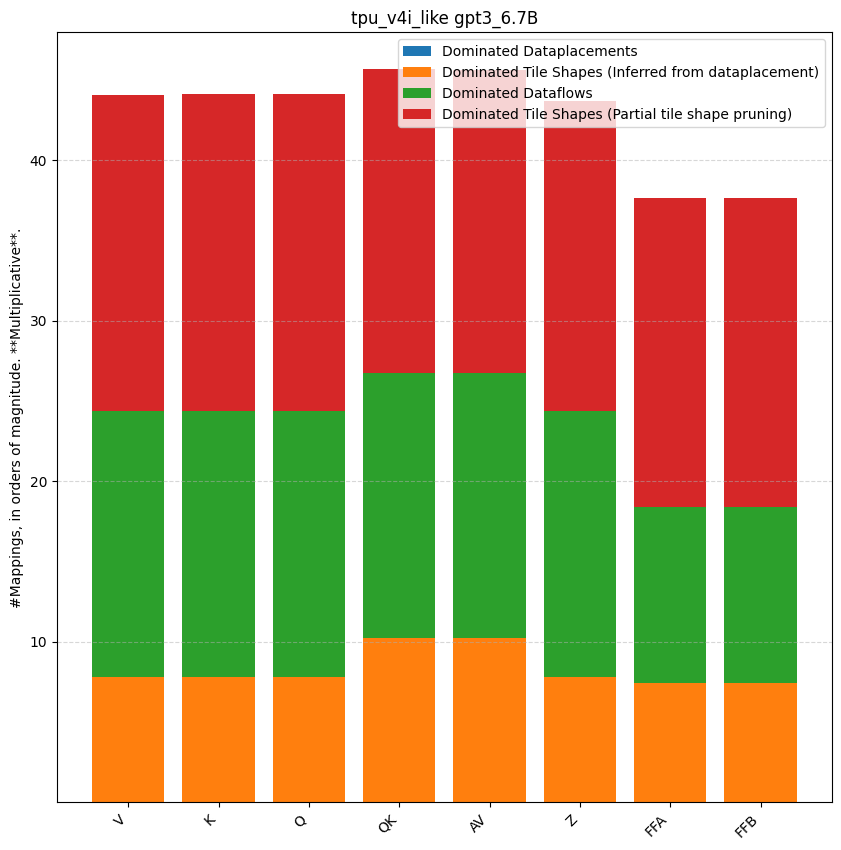

In [3]:
import matplotlib.pyplot as plt
plt.style.use("default")
import numpy as np

def _plot_format(ax: plt.Axes):
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.legend()
    # ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=1)

def make_stacked_bar_chart(
    results: dict[str, dict[str, float]],
    ax: plt.Axes
):
    categories = list(next(iter(results.values())).keys())
    labels = list(results.keys())
    data = list(zip(*results.values()))
    bottom = [0] * len(labels)
    for i, cat in enumerate(categories):
        ax.bar(labels, [results[l][cat] for l in labels], label=cat, bottom=bottom)
        bottom = [b + v for b, v in zip(bottom, [results[l][cat] for l in labels])]
    _plot_format(ax)
    ax.set_xticklabels(labels, rotation=45, ha="right")

einsums = [e.name for e in spec.workload.einsums if len(e.tensor_accesses) > 2]# + ["Total"]

results = {
    e: {
        # "Evaluated by Mapper": remaining[e],
        "Dominated Dataplacements": redundant_dataplacements_reduction[e],
        "Dominated Tile Shapes (Inferred from dataplacement)": non_helpful_tile_shapes_reduction[e],
        "Dominated Dataflows": redundant_loop_orders_reduction[e],
        "Dominated Tile Shapes (Partial tile shape pruning)": pruned_tile_shapes_reduction[e],
        # "Dominated Tile Shapes 2": pruned_tile_shapes_reduction[e],
        # "Non-Helpful Loops for Permutations": non_helpful_loops_for_loop_orders_reduction[e],
    } for e in einsums
}

fig, ax = plt.subplots(figsize=(10, 10))
make_stacked_bar_chart(results, ax)
ax.set_title(f"{arch.split('/')[-1].split('.')[0]} {workload.split('/')[-1].rsplit('.', 1)[0]}")
ax.set_ylabel(f"#Mappings, in orders of magnitude. **Multiplicative**.")
plt.show()

In [4]:
joined = ff.mapper.FFM.join_pmappings(spec, normal)
joined[0].render()

Einsum I has 1 pmappings with 1 compatibilities
Einsum V has 1 pmappings with 1 compatibilities
Einsum K has 1 pmappings with 1 compatibilities
Einsum Q has 1 pmappings with 1 compatibilities
Einsum QK has 1 pmappings with 1 compatibilities
Einsum QK_softmax has 1 pmappings with 1 compatibilities
Einsum AV has 1 pmappings with 1 compatibilities
Einsum Z has 1 pmappings with 1 compatibilities
Einsum FFA has 1 pmappings with 1 compatibilities
Einsum FFB has 1 pmappings with 1 compatibilities


Compressing pmappings: 100%|██████████| 10/10 [00:00<00:00, 918.70it/s]


Not tracking ArrayDummy because it is never reserved for multiple pmappings.
Not tracking GlobalBuffer because it is never reserved for multiple pmappings.
Not tracking LocalBuffer because it is never reserved for multiple pmappings.
Not tracking MainMemory because it is never reserved for multiple pmappings.
Not tracking Register because it is never reserved for multiple pmappings.


Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 10538.45it/s]


In [5]:
import functools
from math import ceil, comb

@functools.lru_cache(maxsize=None)
def _count_factorizations_imperfect(M, N):
    # Factorize M into N parts
    RUBY_STYLE_IMPERFECT = False
    if M <= 1:
        return 1
    if N <= 0:
        return 1

    shapes = list(range(1, ceil(M ** 0.5) + 1))
    shapes = shapes + [ceil(M / s) for s in shapes]
    shapes = sorted(set(shapes))

    if RUBY_STYLE_IMPERFECT:
        shapes = list(range(1, M + 1))

    total = 0
    for s in shapes:
        n = _count_factorizations_imperfect(ceil(M / s), N - 1)
        # print('\t' * (8 - M) + f'{s} ({n})')
        total += _count_factorizations_imperfect(ceil(M / s), N - 1)

    return total


def _prime_factorization(M):
    f = []
    i = 2
    while M > 1:
        if M % i == 0:
            f.append(i)
            M //= i
        else:
            i += 1
    return f


def _count_factorizations(M, N, imperfect=False):
    # Factorize M into N parts
    if imperfect:
        return _count_factorizations_imperfect(M, N)

    if N <= 1:
        return 1
    f = _prime_factorization(M)
    factors = {f2: f.count(f2) for f2 in set(f)}
    total = 1
    for exp in factors.values():
        total *= comb(exp + N - 1, N - 1)  # n choose k
    return total


x = 28
for i in range(5, 8):
    print(f"{i}: {_count_factorizations(x, i, imperfect=False)} -> {_count_factorizations(x, i, imperfect=True)}")

5: 75 -> 735
6: 126 -> 1414
7: 196 -> 2514
